# **🔋 Battery Modelling - EDF R&D 2025**
### **Project Overview**
##### - **Team Members:** Hugo Tran, Etienne Guegan, Akira Kuroda, Tianhe Li
##### - **Goal:** Model battery impedance evolution relative to the battery's age
##### - **Data:** Battery cell voltage, current, and test cycles.  

### **Table of Contents**
##### - Context
##### - Description of approach and models used
##### - Results
##### - References



### **Context**
This project focuses on modelling battery behavior under various ageing conditions. It includes implementations for calculating State of Charge (SoC) and State of Health (SoH) of the cell, along with zero-order and first-order (RC (Resistor-Capacitor)) equivalent circuit models, predicting approximate battery dynamics.



### How to Run the Report Code

#### 1. Necessary imports

In [55]:
# Python modules
import data as dt
import plot as pt

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import cumulative_trapezoid


### <ins>File Structure</ins>

Our code is split into the following modules: \ 
- ***data.py*** regroups all the data manipulation functions needed for the model generation
- ***plot.py*** regroups all plotting function we have elaborated
- ***main.py*** runs a selection of important functions, and can be used for inputing client code


---
## **Description of approach and models used**

We are tasked to simulate the battery cells' behaviour over time, as the cells age.

The following project plan was elaborated:
<br>
**1/** Define what tools are at our disposal
<br>
**2/** Understanding and calculating State of Charge (SoC) and State of Health (SoH)
<br>
**3/** Choosing a model and measuring model parameters
<br>
**4/** Plotting parameters in function of SoC and SoH
<br>
**5/** Error quantification and model improvement

### **1/ What tools are at our disposal?**
Two sets of files, for two different cells: C and D, were available for our analysis. Each file represented a cell **check-up**, recording voltage response to a current input.

One can observe that the given data for cell C and D contains the total time, current, voltage and step. We decided to plot the current, voltage and step in function of the time elapsed.

The ```plot_test(cell, test)``` function, that takes as arguments the cell type ("C" or "D") and the test number ("01" for example) (both in ```String```) allowed us to plot the following:

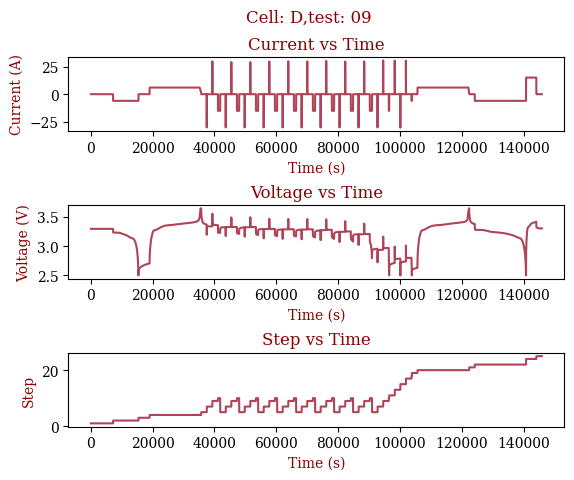

In [56]:
pt.plot_test("D", "09")



<div align = "center">
    <img src = "img/data_cell_d_test_09.png" alt = "Data plot of Test 9 of Cell D in function of the total time" width = "900"/>
</div>

2 things are to be noted for our modelling:
- The recorded values are **discrete**, which must be taken into consideration for future parameter measurement.
-  2 important regions can be discerned. In the **pulse region**, the current varies quickly, reproducing a similar effect on voltage. In the **discharge region**, the battery undergoes a full discharge and voltage progressively goes from maximum value to minimum value.

### **2/ SoC and SoH**

Before looking into these two battery characteristics, it is important to define **capacity**.

The **capacity** of a battery, measured in **Ampere-hours (Ah)**, represents the total charge it can store and deliver.  
With ageing, the available capacity decreases, meaning an older battery can deliver less charge than a new one.

The total capacity for a check-up is calculated as the integral of the **current** cycle over time over a **full discharge**:

$$
Q_{\text{remaining}} = \int_{full \: discharge} I(t) \, dt
$$

where:
- ***$Q_{remaining}$*** is the remaining charge in **Ah**,
- ***I(t)*** is the discharge current at time \( t \).

We plan to calculate the capacity of the battery by measuring the integral of the current over the **full discharge** region of the data. 

<ins>State of charge:</ins>

The **State of Charge (SoC)** of a battery, expressed as a **percentage (%),** represents the available charge relative to its remaining capacity for that check-up. 
It is equivalent to the indicated battery percentage on smartphones.

The SoC at a given time is calculated as the ratio of the available charge over the remaining capacity:

$$
\text{SoC}(t) = \frac{Q_{\text{available(t)}}}{Q_{\text{remaining}}} \times 100
$$

where:  
- ***SoC(t)*** is the **State of Charge** at time \( t \) in **%**,  
- ***$Q_{available}$*** is the available charge in **Ah** of the remaining total,  
- ***$Q_{remaining}$*** is the remaining (rated) capacity of the battery in **Ah**.

$Q_{available}$ at a time t can be found by substracting the total capacity for the check-up ($Q_{remaining}$) and the integral of the current before the time t (the capacity).


<ins>State of health:</ins>

The **State of Health (SoH)** of batteries corresponds to the ratio of the remaining total capacity for a given check-up over the initial total capacity. In other words, it can inform us on how much capacity the battery has lost due to ageing. The SoH is expressed in percentage by the following equation:


$$
SoH [\%] = \frac{Q_{remaining}}{Q_{initial}}
$$

Assuming the battery is not damaged initially and is at full total capacity, we can say that $Q_{initial}$ is total capacity of the battery for the first check-up.





### **3/ Choosing a model and measuring model parameters**

We plan to use an **Equivalent Circuit Thevenin Model** to simulate our battery.

An Equivalent Circuit Model models the dynamics of a battery by an electric circuit.

The Thevenin model uses a specific circuit, composed of a voltage source, a resistance representing the internal resistance of the battery, and n RC loops, for a model of order n.

**Advantages of the model**
The model provides a dynamic and accurate (more or less depending on the order) simulation of the battery while applying simple concepts. The model requires the resolution of 1st year electrical circuit equations to calculate a small number of parameters, therefore previously acquired knowledge may be applied.

Moreover, this model has already been frequently applied to model Lithium Ion batteries, and many research papers can be found concerning it.

**Limits of the model**
One limitation of this model is precision: other models exist with higher accuracy, however they require more calculations.


We plan to use first a 0th order Thevenin model and adapt it into a 1st order Thevenin model. Depending on the accuracy of the 1st order, we may move on to the 2nd order, however we suppose that the increase in the accuracy of the model will be low compared to the increase in calculations needed.


<ins>Model Parameters</ins>

<div align = "center">
<img src = "img/circuit_zero_order.png" alt = "0th order / Rint Model circit" width = "500"/>
</div>

For the **0th order model**, the following equation of $U_L$ can be found:

$$
U_L = U_{OC} - U_0
\implies U_L = U_{OC} - I_L \cdot R_{0}
$$

Two parameters may be identified: open circuit voltage ($U_{OCV}$) and resistance ($R_{0}$).

The open circuit voltage is defined as the voltage of the battery when no current has been applied to it for a sufficiently long amount of time (1 or 2 hours).

This translates graphically (approximately) to finding the voltage of the battery when its current is equal to ```0 Amps```. For instance for cell D test 9, the circled portions of the graphs correspond to its OCV.

<div align = "center">
<img src = "img/finding_ocv.png" alt = "Finding OCV" width = "700"/>
</div>

The resistance $R_{0}$ can be described as the resistance that acts instantly on the battery. Taking inspiration from the resource given, we establish the equation of the internal resistantce $R_0$ by:

$$
R_0 = \frac{U_A - U_B}{I_L}
$$

where $U_A$ and $U_B$ are found graphically. Below is an image of finding the four voltages per pulse.

<br>
<div align = "center">
<img src = "img/find_ua_ub_uc_ud.png" alt = "Finding UA UB UC UD" width = "700"/>
<p>Figure 1: Graph of the voltage during a current pulse. We can determine the voltages at points A, B and C</p>
<p>Source: Ruoyu Xu, "Lithium-ion battery modeling and SoC estimation", 2023 Kth Royal Institute of Technology, </p>
</div>
<br>

By zooming in on our data, we observe that for each current pulse, the voltage follows a similar graph, where $U_A$ and $U_B$ can be extracted. In fact, we will take $U_A$ = $U_{OCV}$.  Below is an example of that of cell D on test 9. We observe that this pattern happens for a current pulse of around ```-30 Amps```.

<div align = "center">
<img src = "img/voltage_cell_d_test_9_49800s.png" alt = "Voltage after a current pulse of -30A" width = "900"/>
</div>


<div align = "center">
<img src = "img/circuit_first_order.png" alt = "1st order / Thevenin Model circit" width = "500"/>
</div>

For the **1st order model**, the following equation can be found:

$$
U_L(t) = U_{OC} - I_L \cdot R_0 - I_L \cdot R_1 \cdot (1 - e^{-\frac{t}{\tau_1}})
$$

Two more parameters can be identified: the RC loop resistance ($R_{1}$) and capacitance ($C_{1}$).

$R_{1}$ acts upon the exponential part of the pulse, and can be calculated as follows:

$$
R_1 = \frac{U_{B} - U_{C}}{I_{L}}
$$

On the other hand, measuring $C_{1}$ on the graph seems improbable. Thus, we will measure $\tau$ as the characteristic time of the loop and deduce the capacitance via $\tau = R_{1}*C_{1}$. Out of many other methods, measuring $\tau$ can be achieved either by finding one third of the time for 95 % of the voltage difference between $U_{B}$ and $U_{C}$ to be reached, or taking the time for 63% of that difference to be reached. We will choose our method by comparing the given model results.

### 4/ Plotting parameters in function of SoC and SoH

Since our model depends only on the input current, the SoC and the SoH, we must establish a relation between the parameters of the model and the SoC and SoH.

To establish a relation between our parameters and **SoC**, we will measure our parameters for a range of SoC values, and curve fit the data using the Numpy function: ```polyfit()```.

An **SoH** relation can be inferred from knowing which test the model is applied to, since we assume that the SoH does not vary a lot over a check-up.

### 5/ Error quantification and model improvement

To quantify the error of our model, we can measure the difference in voltage between the real data and the model voltage, or the distance of the two voltages.

To improve our model, we can apply the model to a single impulse, allowing us to test different measurements of parameters, and apply our newly acquired knowledge to our general model.



---
## **Results**




### **SoC and SoH Plots** 

### <ins>Capacity Definition</ins>
The **capacity** of a battery, measured in **Ampere-hours (Ah)**, represents the total charge it can store and deliver.  
With ageing, the available capacity decreases, meaning an older battery holds less charge than a new one.

The capacity during a **full discharge** cycle is calculated as the integral of the **current** over time:

$$
Q_{\text{remaining}} = \int_{full \: discharge} I(t) \, dt
$$

where:
- ***$Q_{remaining}$*** is the remaining charge in **Ah**,
- ***I(t)*** is the discharge current at time \( t \).

## **State of Charge** (SoC)

### <ins>Definition</ins>
The **State of Charge (SoC)** of a battery, expressed as a **percentage (%),** represents the available charge relative to its remaining capacity.
As a battery discharges, its **SoC decreases**, indicating how much charge is left compared to its *initial* full capacity.

The SoC at a given time is calculated as the ratio of the available charge to the remaining capacity:

$$
\text{SoC}(t) = \frac{Q_{\text{available(t)}}}{Q_{\text{remaining}}} \times 100
$$

where:  
- ***SoC(t)*** is the **State of Charge** at time \( t \) in **%**,  
- ***$Q_{available}$*** is the available charge in **Ah** of the remaining total,  
- ***$Q_{remaining}$*** is the remaining (rated) capacity of the battery in **Ah**.

 In our SoC calculations, we integrated the current displayed during the tests provided in order to get the *Q_remaining*. We then established boundaries for our SoC reaching 100% at its maximum and 0% at its minimum as the full discharge is done. \
 Assuming an initial full charge at \( t = 0 \):

$$
\text{SoC}(t) = \text{SoC}_{\text{initial}} - \frac{1}{Q_{\text{remaining}}} \int_0^t I(\tau) \, d\tau
$$

where:

- ***$Q_{initial}$*** is the initial State of Charge (usually 100%),  
- ***I(t)*** is the discharge current at time \( t \).

### <ins>Plotting the SoC</ins>
In order to illustrate the plot of the **State of Charge (SoC)** of a given cell, the following function ```plot_soc``` calls our SoC plot function which takes as arguments the specific cell and test wanted:

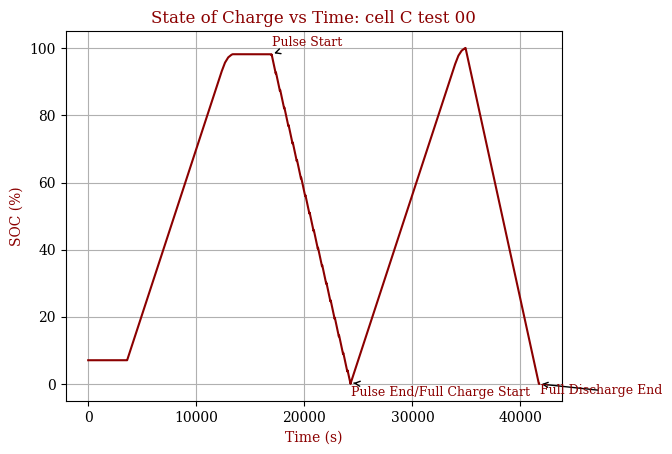

In [57]:
from plot import *

pt.plot_soc("C","00")


#### ***Analysis***

The **State of Charge (SoC) vs. Time graph** shows the charge and discharge behaviour of the ***cell "C"*** over the **test cycle "00"**. Initially, the SoC starts at a **low percentage** and gradually increases as the battery is charged. The overall pattern represents a controlled experimental setup designed to assess the battery’s response to repeated charge and discharge cycles. 

Once it reaches 100%, the battery undergoes a **series** of **charge and discharge cycles** before eventually reaching a full discharge at the end of the test. 

In the middle of the graph, we observe pulsed discharges, where the **SoC drops sharply** after reaching full charge. This pattern repeats, indicating that the battery is undergoing controlled pulse discharges. Such behaviour is common in battery characterization tests, particularly pulse current tests, which evaluate battery performance under **dynamic** conditions. These tests help assess **capacity retention**, **efficiency**, and the effects of **cycling** on battery health. 

At the end of the test, the SoC fully discharges to 0% and remains there, suggesting a **complete depletion** of the battery. This final discharge is the way we measure the battery’s total usable energy before recharge. 

---
## **State of Health** (SoH)

The State of Health (SoH) of batterries correspond to the ratio of the remaining capacity at a given time to the initial capacity. In other words, it shows how much capacity the battery has lost due to ageing. The SoH is expressed in percentage by the following equation:


$$
SoH [\%] = \frac{Q_{remaining}}{Q_{initial}}
$$


We decided to plot the SoH of cells C and D in function of their test value. Cell C has 23 tests, while cell D has 13. Test 00 is be the start of the experiment, meaning that the batteries are new in this test.


The following function ```plot_soh(cell)``` from the ```plot``` file takes ```"C"``` or ```"D"``` as argument. We plot the SoH of cell C:

I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function

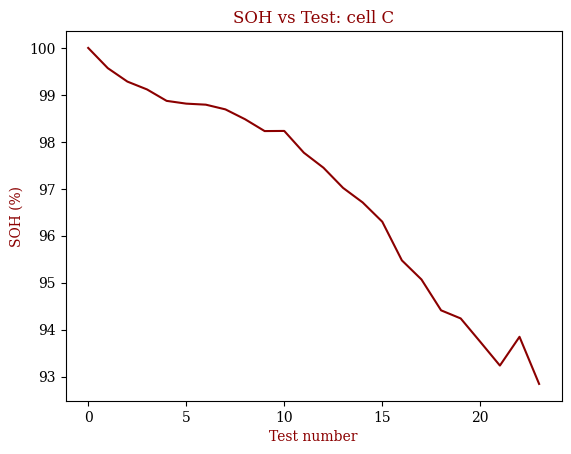

In [58]:
pt.plot_soh("C")


We get the following images:

<div align = "center">
    <img src = "img/soh_c.png" alt = "Image of SoH of Cell C in function of the tests" width = "575"/>
    <img src = "img/soh_d.png" alt = "Image of SoH of Cell D in function of the tests" width = "575"/>
</div>


## **Analysis of the State of Health (SoH) and Ageing Dynamics**

#### **General Decline Analysis of SoH for Cells C and D**

The SoH charts for Cells C and D display **agreeable degradation**, this behaviour is in alignment with lithium-ion battery nature. Under long-term testing, various chemical and structural ageing processes affect the cell's performance. 

Ageing of a cell is affected by various factors, including the accumulation of the **Solid Electrolyte Interphase (SEI)** layer, lithium corrosion, and the loss of active material on the Cathode and Anodes of a cell. The SEI sheet serves a pivotal role by streamlining lithium-ion (Li+) exchange between electrodes. It also intercepts electrons to prevent excessive electrolyte decay, and by doing so preserves the battery's chemical composition. As this SEI layer grows over time, it increases internal resistance and reduces battery efficiency.

As time goes on and the cell is used more and more, additional degradation processes affect it. The apparition of damage to the electrodes structure, alongside electrolyte decomposition, also contribute to the reduction of cell capacity. 

---

#### **Cell C (23 Test Intervals)**

- **Initial Phase (Tests 0 to ~10):**  

- **Middle Phase (~Test 10 to Test 14):**  

- **Later Phase (~Test 14 to Test 23):**  

---

#### **Cell D (13 Test Intervals)**

- **Initial Phase (Tests 0 to ~4):**  

- **Middle Phase (~Test 4 to Test 8):**  

- **Final Phase (~Test 9 to Test 13):**  

---

#### **Physical Interpretation of Degradation**

The degradation pattern observed make total sense when referring to the physical and chemical reactions occurring within lithium-ion cells:

1. **Early Phase (Stabilization):**  
   During the initial usage period, the SEI layer forms, which is beneficial for stabilizing the battery chemistry. However, it gradually consumes lithium ions, leading to a minor capacity loss.

2. **Middle Phase (Accelerated Ageing):**  
   As the battery undergoes more charge/discharge cycles, SEI thickening increases internal resistance, reducing energy efficiency. Lithium plating and further chemical side reactions could explain the increased degradation of the capacity. If this indeed occurs, the impedance growth limits charge transport, which ultimately contributes to a steeper decline in SoH. Given that the graphs consistently display a decrease in the tangent of their SoC, we can assume that this degradation is occurring inside the cells, as more and more tests are done.

3. **Last Phase (End-of-Life Characteristics):**  
   Once again the tangent SoC line decreases even more, even more electrolyte decomposition and chemical damage to the electrodes can be supposed. The pronounced and more abrupt decreases recorded may hint at widespread interior changes, as all the previously listed affects worsen. We could interpret this as the indication of the cell’s approach of its end-of-life (EoL) stage, though this interpretation remains speculative.



These complex ageing dynamics make it essential for Battery Management Systems (BMS) to accurately estimate SoH and manage battery usage efficiently. Accurate SoH estimation not only improves the charging/discharging process but also helps predict battery lifespan and optimize the operation of EVs and other energy storage systems.

As batteries age, it is expected that their capacity degrades due to chemical and structural changes inside the cells, leading to a decline in SoH.

--

## **ECM parameters as functions of SoC and SoH** 

### **ECM of order zero**

#### Finding $U_{OC}$

From the resource given, $U_{OC}$, or Open Circuit Voltage, is found when the battery has been at rest for a long enough time (1 or 2 hours). 
This translates graphically to finding the voltage of the battery when its current is equal to ```0 Amps```. For instance for cell D test 9, the circled portions of the graphs correspond to its OCV.

<div align = "center">
<img src = "img/finding_ocv.png" alt = "Finding OCV" width = "700"/>
</div>

Below is the code of the dataframe of cell D on test 9, where we keep the values such that its current is equal to ```0 Amps```.

In [59]:
print(dt.find_OCV("D", "09")) # Dataframe with OCV extracted

print(dt.soc_ocv("D", "09")) # Dataframe with OCV extracted, and SoC calculated


       Total Time  Current  Voltage  Step
2142      41868.3      0.0    3.301     5
2919      48008.8      0.0    3.286     5
3696      54149.3      0.0    3.269     5
4473      60289.8      0.0    3.259     5
5250      66430.3      0.0    3.247     5
6027      72570.8      0.0    3.230     5
6804      78711.3      0.0    3.205     5
7581      84851.8      0.0    3.164     5
8358      90992.3      0.0    2.897     5
11160    144146.9      0.0    3.341    25
    Total Time    Current    OCV       SoC
0      39328.8  21.463333  3.341  0.909923
1      43659.3 -30.046667  3.328  0.814324
2      49799.8 -30.030000  3.324  0.715062
3      55940.3 -30.026667  3.294  0.615801
4      57750.3  21.586667  3.295  0.612171
5      62080.8 -30.010000  3.288  0.516632
6      63890.8  21.623333  3.290  0.512976
7      68221.3 -30.040000  3.286  0.417464
8      70031.3  21.566667  3.288  0.413804
9      74361.8 -30.030000  3.274  0.318259
10     76171.8  21.850000  3.278  0.314618
11     80502.3 -30.030

However, since we can only measure the voltage after a pulse, we only get a sample of the OCV. So we can only establish a discrete relationship between the OCV and the SoC. 

To get its continuous version, we apply curve fitting thanks to the ```np.polyfit``` function.
We therefore have the following code:

In [60]:
pt.model_data_soc_ocv("C", "01")


AttributeError: module 'plot' has no attribute 'model_data_soc_ocv'

In [7]:
soc = dt.soc_ocv("D", "09")["SoC"] # Extract the OCV from the dataframe
ocv = dt.soc_ocv("D", "09")["OCV"] # Extract the SoC from the dataframe

# Fit a polynomial of degree 5
coefficients = np.polyfit(soc, ocv, 5) # Curve fitting the SoC in function of the OCV by a 5th degree polynomial 
polynomial = np.poly1d(coefficients) # Store the coefficients in the polynomial

# Thus, given an OCV, we can find the SoC by executing: polynomial(OCV)


NameError: name 'np' is not defined

So we finally get $U_{OC}$ in function of the SoC.

#### Finding $R_0$

Taking inspiration from the resource given, we establish the equation of the internal resistantce $R_0$ by:

$$
R_0 = \frac{U_A - U_B}{I_L}
$$

where $U_A$ and $U_B$ are found graphically. Below is an image of finding the four voltages per pulse.

<br>
<div align = "center">
<img src = "img/find_ua_ub_uc_ud.png" alt = "Finding UA UB UC UD" width = "700"/>
<p>Figure 1: Graph of the voltage during a current pulse. We can determine the voltages at points A, B and C</p>
<p>Source: Ruoyu Xu, "Lithium-ion battery modeling and SoC estimation", 2023 Kth Royal Institute of Technology, </p>
</div>
<br>
<br>

We observe that for each current pulse, the voltage follows a similar graph by zooming in. Below is an example of that of cell D on test 9. We observe that this pattern happens for a current pulse of around ```-30 Amps```.

<div align = "center">
<img src = "img/voltage_cell_d_test_9_49800s.png" alt = "Voltage after a current pulse of -30A" width = "900"/>
</div>

For each pulse, we get its associated SoC. Similarly for the $U_{OC}$, we only have a discrete relationship with the SoC. 
To get its continuous version, we apply curve fitting by executing the following code:

In [ ]:
soh_value = dt.soh("D","09")
#global soh_value
time_between_dupes = 300
df = dt.extract("D","09")
df["SoC"] = dt.soc("D","09")
df["R0"] = [dt.R0_fit.f(soc_value,soh_value) for soc_value in  dt.df["SoC"]]
print(df)


Knowing the two variables, we get the following simulation for the output voltage:

I am in the SOH function
I have Q remaining
I have q initial


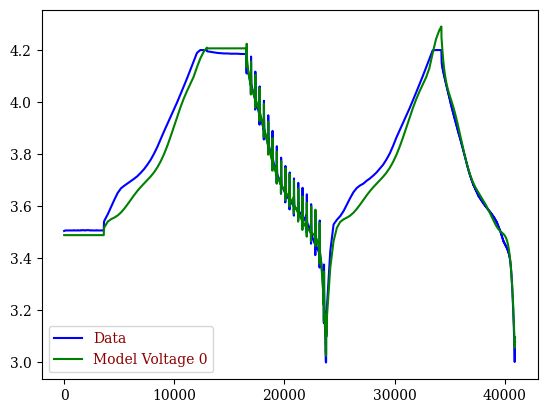

In [11]:
pt.plot_simultaneous_0("C", "09")


### **First order ECM**

$R_0$ and $U_{OC}$ are found using the results of the Rint Model. So we only need to determine $R_1$ and $C_1$.

#### Finding $R_1$

From the resource given, we get:

$$ R_1 = \frac{\mid U_C - U_B \mid}{I_L} $$

$U_C$ and $U_B$ are determined by finding the voltages during the current pulse of ```-30 Amps```. 

We finally apply curve fitting similarly to the startegies applied in the 0th order model.

#### Finding $\tau_1$


$\tau_1$ corresponds to the time at which the voltage reach 63% of the difference during the ```B-C``` phase of the pulse. Graphically, we have:

<div align = "center">
<img src = "img/find_tau.png" alt = "Image describing how to find tau" width = "900"/>
</div>

We apply curve fitting for a continuous relationship between $\tau_1$ and SoC.

The graph of the modelled output and that of the data given is found below

I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
calculated model 0


c:\Users\akira\OneDrive\ドキュメント\Game Development\Python\EDF_Batteries\data.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split["R1"] = abs(split["Voltage"].iloc[0] -
c:\Users\akira\OneDrive\ドキュメント\Game Development\Python\EDF_Batteries\data.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split["R1"] = abs(split["Voltage"].iloc[0] -
c:\Users\akira\OneDrive\ドキュメント\Game Development\Python\EDF_Batteries\data.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

r1       Total Time  Current  Voltage  Step       SoC        R0       OCV  \
120      16968.3    -32.0    4.128     7  0.982137  0.001839  4.198739   
121      16969.3    -32.0    4.126     7  0.981841  0.001839  4.197820   
122      16970.3    -32.0    4.124     7  0.981544  0.001839  4.196906   
123      16971.3    -32.0    4.122     7  0.981248  0.001839  4.195997   
124      16972.3    -32.0    4.121     7  0.980952  0.001838  4.195093   
...          ...      ...      ...   ...       ...       ...       ...   
1277     23990.1    -32.0    3.239     7  0.034964  0.002590  3.335077   
1278     23991.1    -32.0    3.236     7  0.034668  0.002592  3.333609   
1279     23992.1    -32.0    3.233     7  0.034371  0.002595  3.332133   
1280     23993.1    -32.0    3.230     7  0.034075  0.002597  3.330648   
1281     23994.1    -32.0    3.227     7  0.033779  0.002600  3.329154   

            R1  
120   0.000405  
121   0.000404  
122   0.000403  
123   0.000402  
124   0.000401  
...   

c:\Users\akira\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
8141    inf
8142    inf
8143   -inf
8144    NaN
8145    NaN
Length: 8146, dtype: float64
      Total Time  Current  Voltage  Step       SoC        R0       OCV  \
119      16967.3      0.0    4.185     6  0.982285  0.001839  4.199201   
120      16968.3    -32.0    4.128     7  0.982137  0.001839  4.198739   
121      16969.3    -32.0    4.126     7  0.981841  0.001839  4.197820   
122      16970.3    -32.0    4.124     7  0.981544  0.001839  4.196906   
123      16971.3    -32.0    4.122     7  0.981248  0.001839  4.195997   
...          ...      ...      ...   ...       ...       ...       ...   
1278     23991.1    -32.0    3.236     7  0.034668  0.002592  3.333609   
1279     23992.1    -32.0    3.233     7  0.034371  0.002595  3.332133   
1280     23993.1    -32.0    3.230     7  0.034075  0.002597  3.330648   
1281     23994.1    -32.0    3.227     7  0.033779  0.002600  3.329154   
1282     23995.2      0.0

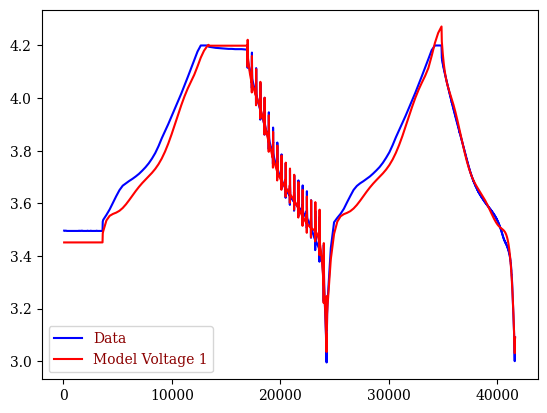

In [13]:
pt.plot_simultaneous_1("C", "01")


### ECM of order zero (Rint Model)
Since we need to simulate an electrical model of the cell based on ECM that is a function of the SoC and SoH, we need to determine its output voltage $U_L$.

At the beginning, we used the Rint Model to study the battery (0th order model). 

<div align = "center">
<img src = "img/circuit_zero_order.png" alt = "0th order / Rint Model circit" width = "500"/>
</div>

Its equation of $U_L$ is:


$$
U_L = U_{OC} - U_0
\implies U_L = U_{OC} - I_L \cdot R_{0}
$$


It is a simple approach to get the output voltage, since we just need to calculate the $U_{OC}$ and the internal resistance $R_0$.

### **ECM of first order (Thevenin Model)**
After finding the output voltage of the Rint Model, we decided to go further and study the battery as a 1st order ECM by using Thevenin's Model.

This approach, despite being complex than its counterpart, allows for more accuracy.

<div align = "center">
<img src = "img/circuit_first_order.png" alt = "1st order / Thevenin Model circit" width = "500"/>
</div>

From the resource given, its equation for $U_L$ is:

$$
U_L(t) = U_{OC} - I_L \cdot R_0 - I_L \cdot R_1 \cdot (1 - e^{-\frac{t}{\tau_1}})
$$

where

$$
\tau_1 = R_1 \cdot C_1
$$


This time, $U_L$ depends on $U_{OC}$, $R_0$, $R_1$ and $\tau_1$.